# ISDIN data challenge

Recogemos los datos de consumo de nuestros clientes en la plataforma online para diferentes regiones en las que opera la compañía. De esta plataforma extraemos algunos detalles el usuario y la fecha en la que estos adquieren los productos. 

De cara a optimizar la red logística y planificar la estrategía, se desea predecir cuáles serán las ventas futuras de cada uno de los productos en la región C, de forma trimestral y para los próximos 4 trimestres.

El director de negocio espera que el informe contenga:
- La preparación de un modelo predictivo en Python.
- La previsiones de ventas para los próximos 4 trimestres.
- Conclusión de los datos obtenidos.
- Principales recomendaciones para mejorar el proceso.

El formato de entrega es un zip con código fuente y la presentación.

## Visualización de los datos y posibles correlaciones

En este apartado pretendemos visualizar los datos, analizando los tipos de variables y este análisis inicial nos ayudará a entender las relaciones entre las variables dependientes e independientes.

### Cargando los paquetes y métodos necesarios

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [19]:
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from statsforecast import StatsForecast
from ray import tune
from dython.nominal import associations
from neuralforecast.auto import AutoLSTM, AutoTCN
from neuralforecast.losses.pytorch import MAE
from os.path import join

from isdin.etl_data import read_csv_data, get_monthly_timeseries, neuralforecast_df_all, neuralforecast_df_region_c, imput_missing_data

### Definiendo la ruta del archivo con los datos y cargándolo

El método de lectura del archivo csv nos devuelve dos pandas dataframes, uno que contiene las variables como variables categóricas para `user_id`, `user_potential`, `region`, `product_id`, `product_family` y `season`, una variable del tipo datetime llamada `transaction_date` y la variable numérica `user_age`. La variable `season` se refiere a la temporada del año en la cual se ha realizado la transacción. Esta variable categórica representa los siguientes meses: 
- `season=0` (Diciembre, Enero y Febrero)
- `season=1` (Marzo, Abril y Mayo)
- `season=2` (Junio, Julio y Agosto)
- `season=3` (Septiembre, Octubre y Noviembre)

El otro dataframe, nos devuelve las mismas variables codificadas para que las utilicemos en los modelos predictivos. Para simplificar el análisis, se han eliminado todas las líneas en las cuales el valor de una de las siguientes variables no estuviera presente: `user_id`, `region`, `product_id`.

In [3]:
filepath = join(".", "data", "sales_data.csv")
data, labelled_df = read_csv_data(filepath)
data.head()

,user_id,user_age,user_potential,region,product_id,product_family,transaction_date,season
0,g3TQxW2Vs0htSP3TNaiu+w==,38.0,3.0,Region D,1.0,family_C,2023-02-13,0
1,CMiS9GAaDCxPgmWLAaemnA==,48.0,7.0,Region C,1.0,family_C,2023-02-13,0
2,CMiS9GAaDCxPgmWLAaemnA==,48.0,7.0,Region C,1.0,family_C,2023-02-13,0
3,Smkz8+f2knM3wln9JpPz5Q==,63.0,0.0,Region C,1.0,family_C,2023-02-13,0
4,95PezHJgs6YTANjN72hxLw==,33.0,7.0,Region B,1.0,family_C,2023-02-12,0


In [4]:
labelled_df.head()

,user_id,user_potential,region,product_id,product_family,season,user_age,transaction_date
0,29791,3,3,0,2,0,38.0,2023-02-13
1,9782,7,2,0,2,0,48.0,2023-02-13
2,9782,7,2,0,2,0,48.0,2023-02-13
3,20798,0,2,0,2,0,63.0,2023-02-13
4,7615,7,1,0,2,0,33.0,2023-02-12


In [5]:
labelled_df.describe()

,user_id,user_potential,region,product_id,product_family,season,user_age,transaction_date
count,54259.000000,54259.000000,54259.000000,54259.000000,54259.000000,54259.000000,27441.000000,54259
mean,21624.246742,4.907186,1.616617,1.762970,0.121141,1.553715,34.628038,2022-07-14 17:21:24.306751232
min,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,18.000000,2021-06-13 00:00:00
25%,10714.500000,2.000000,1.000000,2.000000,0.000000,0.000000,26.000000,2022-03-31 00:00:00
50%,21584.000000,5.000000,2.000000,2.000000,0.000000,2.000000,32.000000,2022-08-14 00:00:00
75%,32528.000000,8.000000,2.000000,2.000000,0.000000,3.000000,40.000000,2022-11-25 00:00:00
max,43315.000000,10.000000,3.000000,5.000000,2.000000,3.000000,121.000000,2023-02-13 00:00:00
std,12549.830348,3.014178,1.033827,0.636049,0.445213,1.239250,15.235250,NaN


Vemos aquí algunas características interesantes de los datos:
- La clase del potencial de cada usuario (`user_potential`) parece estar balanceada, es decir, no tenemos un grupo particularmente fiel o no a un grupo de productos independientemente de la región.
- Los usuarios también están demográficamente distribuidos de manera uniforme (indicado por el promedia de 1.61 en la columna `region`). 
- Sin embargo, los productos con `product_id` igual o inferior a 3 son mucho más populares que los demás, haciendo que el valor promedio del `product_id` se acerque a 1.76 (2.76 con el offset de indexación de las categorias), en lugar de 2.0 (o 3.0 sin offset) como esperado. 
- Suponiendo en este momento, que los `product_id` pertenecen a una `product_family` en concreto, vemos que el promedio de `product_family` indica que la mayoría de los productos se encuentran en la categoria family_A. Como veremos en el siguiente apartado, las variables `product_id` y `product_family` están fuertemente correlacionadas. 

## Visualizando las correlaciones entre variables

Consideramos que nuestro conjunto de datos está compuesto de variables categóricas y numéricas. Por tanto, para visualizar las correlaciones presentes entre variables, tenemos que calcular las correlaciones con distintos métodos. La función de correlación típica asume que los valores numéricos están igualmente separados lo que no es correcto para las variables categóricas. El paquete dython nos permite combinar distintos métodos de calcular la correlación en una [única función](http://shakedzy.xyz/dython/modules/nominal/). Por defecto, aplicamos los siguientes métodos para calcular la correlación:
- **Pearson's R** para relaciones de variables contínua-contínua
- **Correlation ratio** para relaciones de variables categórica-contínua
- **Cramer's V** para relaciones de variables categórica-categórica. 

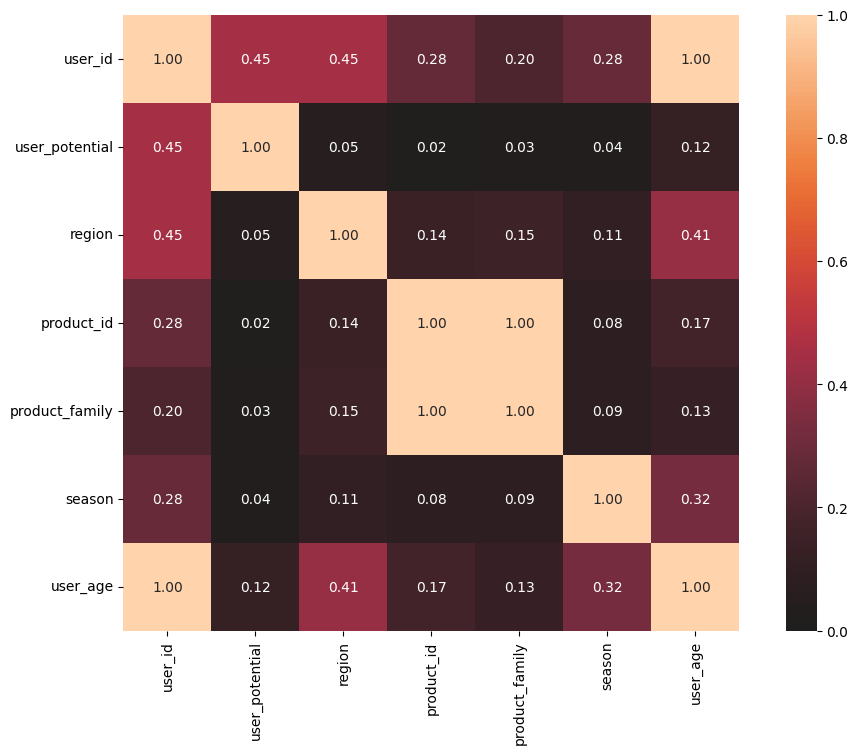

In [4]:
correlations = associations(labelled_df.loc[:, labelled_df.columns != "transaction_date"], numerical_columns= ["user_age"], figsize = (12, 8))

Aquí observamos algunas características de los datos que serán claves para las estratégias de entrenamiento de modelos predictivos:
- Por un lado, el `user_id` que parece ser un código hash está fuertemente correlacionado a `user_age` y también está correlacionado con las variables `user_potential` y `region`. Es natural que cada usuario solo tenga una edad, pero para usuarios que poseen múltiples entradas en distintos años en la base datos, parece no haber una regla para actualizar la edad de los usuarios a partir de la fecha de nacimiento/cumpleaños. Por otro lado, el hecho de que la id de usuario esté parcialmente correlacionado con la variable `user_potential` indica que para un mismo usuario esa cantidad puede variar, es decir que el hecho de crear más o menos entradas en la base datos le cambia su score. Mientras que la correlación parcial con la variable `region` indica que puede haber comprado en distintas regiones. Desde el punto de vista análitico, vamos a utilizar esta información para reducir la dimensionalidad de nuestro problema. 
- Las variables `user_potential`, `region`, `user_age` y `season` parecen no estar fuertemente correlacionadas a las demás variables del conjunto de datos. Para las tres primeras, eso indica una dependencia directa a cada usuario en concreto. Para la variable `season`, lo que notamos es que no hay estacionalidad en los registros respecto a los usuarios o los tipos de producto.
- Una fuerte correlación es observada para las variables `product_id` y `product_family`. Como esperado, cada producto pertenece a una familia en concreto. Lo que nos puede ayudar a reducir la cantidad de variables de nuestros modelos predictivos.

## Entendiendo los productos más populares y la posible existencia de estacionalidad

Ya hemos detectado que algunos productos son mucho más frecuentes que otros. Nos gustaría entender en el presente apartado cuáles son los productos más frecuentes en la base de datos y a qué `product_family` pertenencen. Además, podemos intentar inferir si hay clases de productos más frecuentes en distintas estaciones del año, a pesar del análisis de correlación del apartado anterior indicar lo contrario. 



### Productos más populares

In [5]:
data.groupby(by = ["product_id", "product_family"]).size()

product_id  product_family
1.0         family_A              0
            family_B              0
            family_C           2488
2.0         family_A          10473
            family_B              0
            family_C              0
3.0         family_A          39702
            family_B              0
            family_C              0
4.0         family_A              0
            family_B            605
            family_C              0
5.0         family_A              0
            family_B            990
            family_C              0
6.0         family_A              0
            family_B              0
            family_C              1
dtype: int64

Esa tabla nos muestra que la `family_A` es la familia de productos más popular en la base de datos, siendo el producto 3.0 el más popular de todos. Un buen modelo predictivo tendrá como punto de referencia la varianza expresa en esa tabla. Otra característica es que hay una muestra de producto con `product_id=6` perteneciente a la familia C. Eliminaremos esta muestra para evitar que los modelos capturen la información de esta clase de productos. En los datos hay tres ejemplos de esos productos, pero solo uno posee alguna información sobre el usuario. 

In [35]:
try:
    data["product_id"] = data["product_id"].cat.remove_categories(6.0).dropna()
except ValueError:
    pass

### Productos más populares por región

In [7]:
data.groupby(by = ["product_id", "region"]).size() 

product_id  region  
1.0         Region A      136
            Region B      289
            Region C     1863
            Region D      200
2.0         Region A     2416
            Region B     2519
            Region C     3358
            Region D     2180
3.0         Region A     7151
            Region B     9731
            Region C    13061
            Region D     9759
4.0         Region A        6
            Region B      397
            Region C      130
            Region D       72
5.0         Region A      340
            Region B      301
            Region C       27
            Region D      322
dtype: int64

Una otra característica importante es que los productos más populares en toda la población son igualmente populares en la región de interés de este proyecto (`Region C`). Vemos que los productos de la familia B tienen baja demanda en la `Region C`. 

### Estacionalidad por región y producto

In [8]:
data.groupby(by = ["season", "region"]).size()

season  region  
0       Region A    3311
        Region B    4296
        Region C    4444
        Region D    4893
1       Region A    1086
        Region B    1780
        Region C    3874
        Region D    1602
2       Region A    1622
        Region B    2916
        Region C    4621
        Region D    1799
3       Region A    4030
        Region B    4245
        Region C    5501
        Region D    4239
dtype: int64

Vemos que en la `Region C` no hay estacionalidad, la cantidad total de ventas es practicamente igual durante todo el año. Podemos comprobar si esa frecuencia posee alguna correlación con algún producto en concreto. Comprobamos la proporción de productos por temporada respecto a los valores totales. 

In [9]:
data[data["region"] == 'Region C'].groupby(by = ["season", "product_id"]).size() / data[data["region"] == 'Region C'].groupby(by = ["product_id"]).size()

season  product_id
0       1.0           0.254965
        2.0           0.235259
        3.0           0.239109
        4.0           0.284615
        5.0           0.703704
1       1.0           0.223296
        2.0           0.240917
        3.0           0.201975
        4.0           0.084615
        5.0           0.000000
2       1.0           0.264627
        2.0           0.236152
        3.0           0.252507
        4.0           0.276923
        5.0           0.000000
3       1.0           0.257112
        2.0           0.287671
        3.0           0.306408
        4.0           0.353846
        5.0           0.296296
dtype: float64

Aquí notamos que para los productos 1.0, 2.0, 3.0, y 4.0, practicamente todas las ventas ocurren de manera homogénea durante el año. Sin embargo, la mayoría de las entradas para los productos 5 en la `Region C` se encuentran en los meses de Diciembre, Enero y Febrero. Esa es una información que esperamos capturar en un modelo predictivo.

## Series temporales mensuales

Podemos definir las series temporales mensuales para el total de ventas de cada producto y también por cada región. 

###  Ventas mensuales por producto

Text(0.5, 1.0, 'Total de ventas por región')

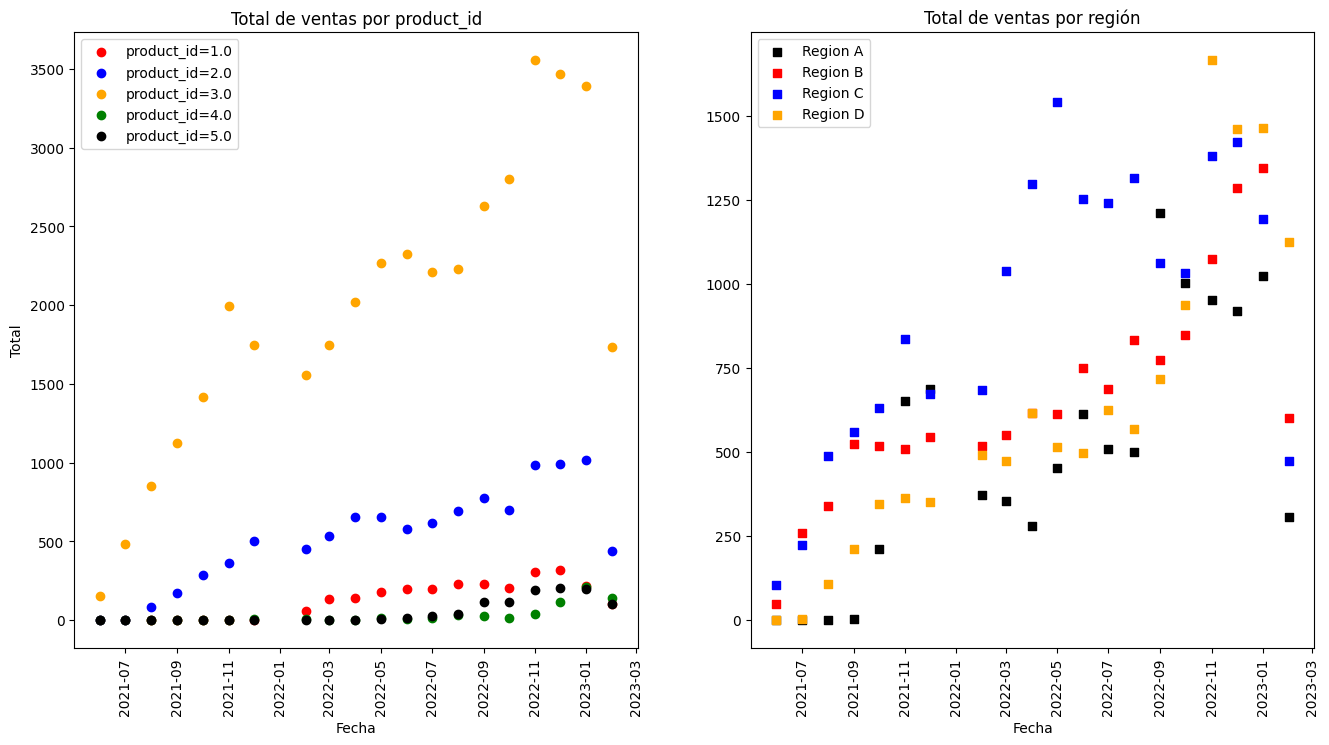

In [5]:
product_timeseries, region_timeseries = get_monthly_timeseries(data)
colors = ["k", "r", "b", "orange", "green"]

fig, ax = plt.subplots(ncols = 2, figsize = (16, 8))
idx_legend = 0
for date, product_dict in product_timeseries.items():    
    for product_id, count in product_dict.items():
        if not idx_legend:
            ax[0].scatter(date, count, color = colors[int(product_id % 5)], label = f"product_id={product_id}")
        else:
            ax[0].scatter(date, count, color = colors[int(product_id % 5)])
    idx_legend += 1
idx_legend = 0
for date, region_dict in region_timeseries.items():
    idx = 0
    for region, count in region_dict.items():
        if not idx_legend:
            ax[1].scatter(date, count, color = colors[int(idx % 4)], label = region, marker = "s")
        else:
            ax[1].scatter(date, count, color = colors[int(idx % 4)], marker = "s")
        idx += 1
    idx_legend += 1

for i in range(2):
    for label in ax[i].get_xticklabels():
        label.set_rotation(90)

ax[0].set_xlabel("Fecha")
ax[0].set_ylabel("Total")

ax[1].set_xlabel("Fecha")

ax[0].legend()
ax[1].legend()

ax[0].set_title("Total de ventas por product_id")
ax[1].set_title("Total de ventas por región")

Esas dos gráficas nos traen informaciones muy importantes:
- Las ventas de todos los productos han aumentado desde Junio de 2021. Como no podemos determinar la causa de ese crecimiento, trataremos esos datos como una serie temporal. Apesar de contener pocos puntos para cada serie individual, podemos determinar agregar las series de cada uno de los productos para predecir cada una de las series temporales. 
- Un comportamiento de crecimiento de las ventas también es observado para cada una de las regiones. Como hemos visto anteriormente, ese crecimiento es principalmente debido a los productos 2.0 y 3.0. 
- En el mes de enero de 2022, no tenemos datos.

## Modelo predictivo

En este apartado, entrenamos un modelo para predecir las ventas en los próximos 4 trimestres. Este apartado se divide en: ingeniería de características, selección de modelos, entrenamiento del mejor modelo y discusión de los resultados.

### Ingeniería de características

En este apartado, extraemos y transformamos los datos disponibles para facilitar/posibilitar el proceso de entrenamiento del model predictivo. Lo primero que haremos es reducir la dimensionalidad de nuestro problema. Vamos a crear series temporales con resolución diaria que nos permitan predecir el valor total de ventas por región. La propuesta es que las series temporales de entrada sean las series temporales de ventas totales por producto por región y tengamos el total de ventas.

In [36]:
dataset = neuralforecast_df_all(data)
dataset = imput_missing_data(dataset)
# dataset.drop(columns = [f"weekday_{i}" for i in range(7)], inplace=True)

### Datos de entrenamiento y validación

Aquí utilizamos los datos hasta diciembre de 2022 para entrenamiento todos los demás para validación.

In [37]:
train = dataset.loc[dataset["ds"] < '2022-12-01']
val = dataset.loc[dataset["ds"] >= '2022-12-01']
horizon = val["ds"].nunique()

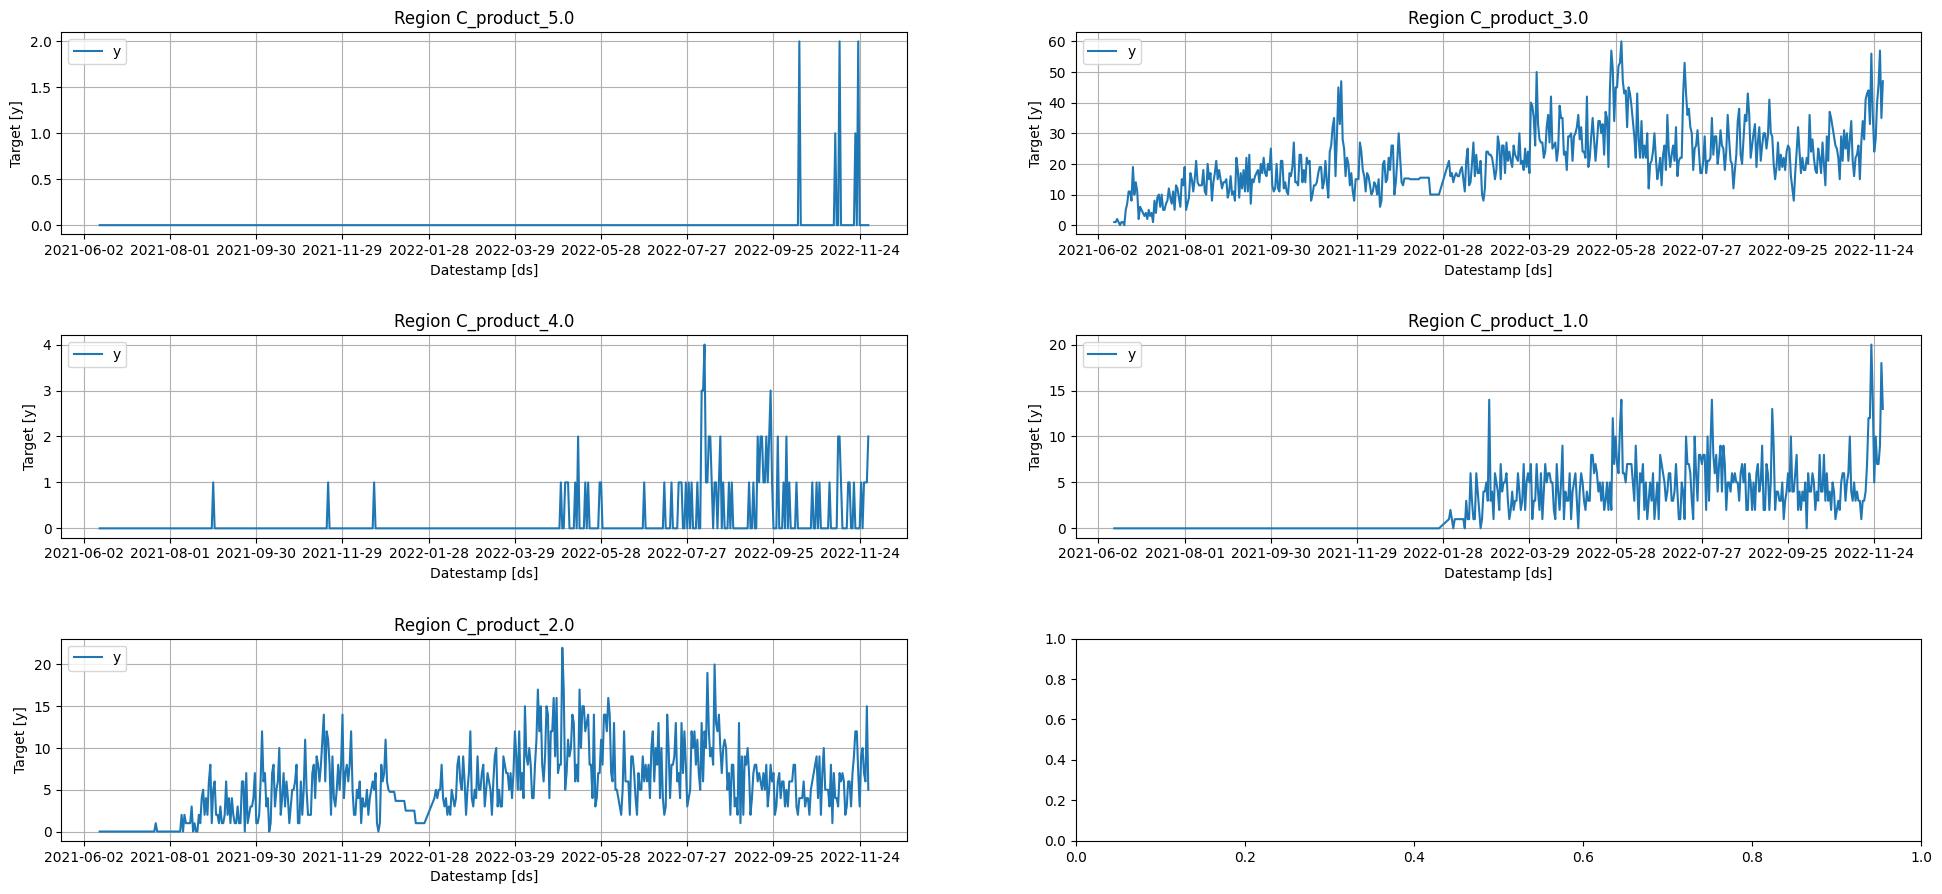

In [38]:
StatsForecast.plot(train[train["unique_id"].str.contains("Region C")], engine = "matplotlib", plot_random=False)

Los datos de entrenamiento están correctamente estructurados. Ahora entrenamos el modelo.

In [39]:
horizon = 90
default_config = {
        "input_size": tune.choice([horizon, 4*horizon, 5*horizon]),
        "learning_rate": tune.loguniform(1e-6, 1e-4),
        "max_steps": tune.choice([250, 500, 750]),
        "batch_size": tune.choice([16, 32, 64]),
        "random_seed": tune.randint(1, 20),
    }

models = [
    AutoTCN(h = horizon, num_samples=3, config = default_config, cpus=2, verbose = True, loss = MAE()),
    AutoLSTM(h = horizon, num_samples=3, config = default_config, cpus=2, verbose = True, loss = MAE()),
]

model = NeuralForecast(models = models, freq = "D")
model.fit(dataset)

(train_tune pid=856870) Global seed set to 9 [repeated 3x across cluster]


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s, v_num=0, train_loss_step=0.792, train_loss_epoch=0.438]
Validation: 0it [00:00, ?it/s] 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(train_tune pid=856949) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s, v_num=0, train_loss_step=0.797, train_loss_epoch=0.435, valid_loss=1.500]
Validation: 0it [00:00, ?it/s] 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(train_tune pid=856949) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s, v_num=0, train_loss_step=0.435, train_loss_epoch=0.434, valid_loss=1.500]
Validation: 0it [00:00, ?it/s] 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(train_tune pid=856949) 
Epoch 99: 100%|██████████| 1/1 [00:01<00:00,  1.60s/it, v_num=0, train_loss_step=0.610, train_loss_epoch=0.607]
Validation: 0it [00:00, ?it/s] 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(train_tune pid=856951) 
Epoch 99: 100%|██████████| 1/1 [00

2023-05-15 22:42:58,235	INFO tune.py:945 -- Total run time: 454.98 seconds (454.97 seconds for the tuning loop).
Global seed set to 9


Epoch 249:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.585, train_loss_epoch=0.585, valid_loss=1.420] [repeated 3x across cluster]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### Generando predicciones para los datos de validación

In [79]:
predictions = model.predict(train)
predictions.reset_index(inplace=True)
predictions.sort_values(by = ["ds", "unique_id"], ascending=[True, True], inplace=True)

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

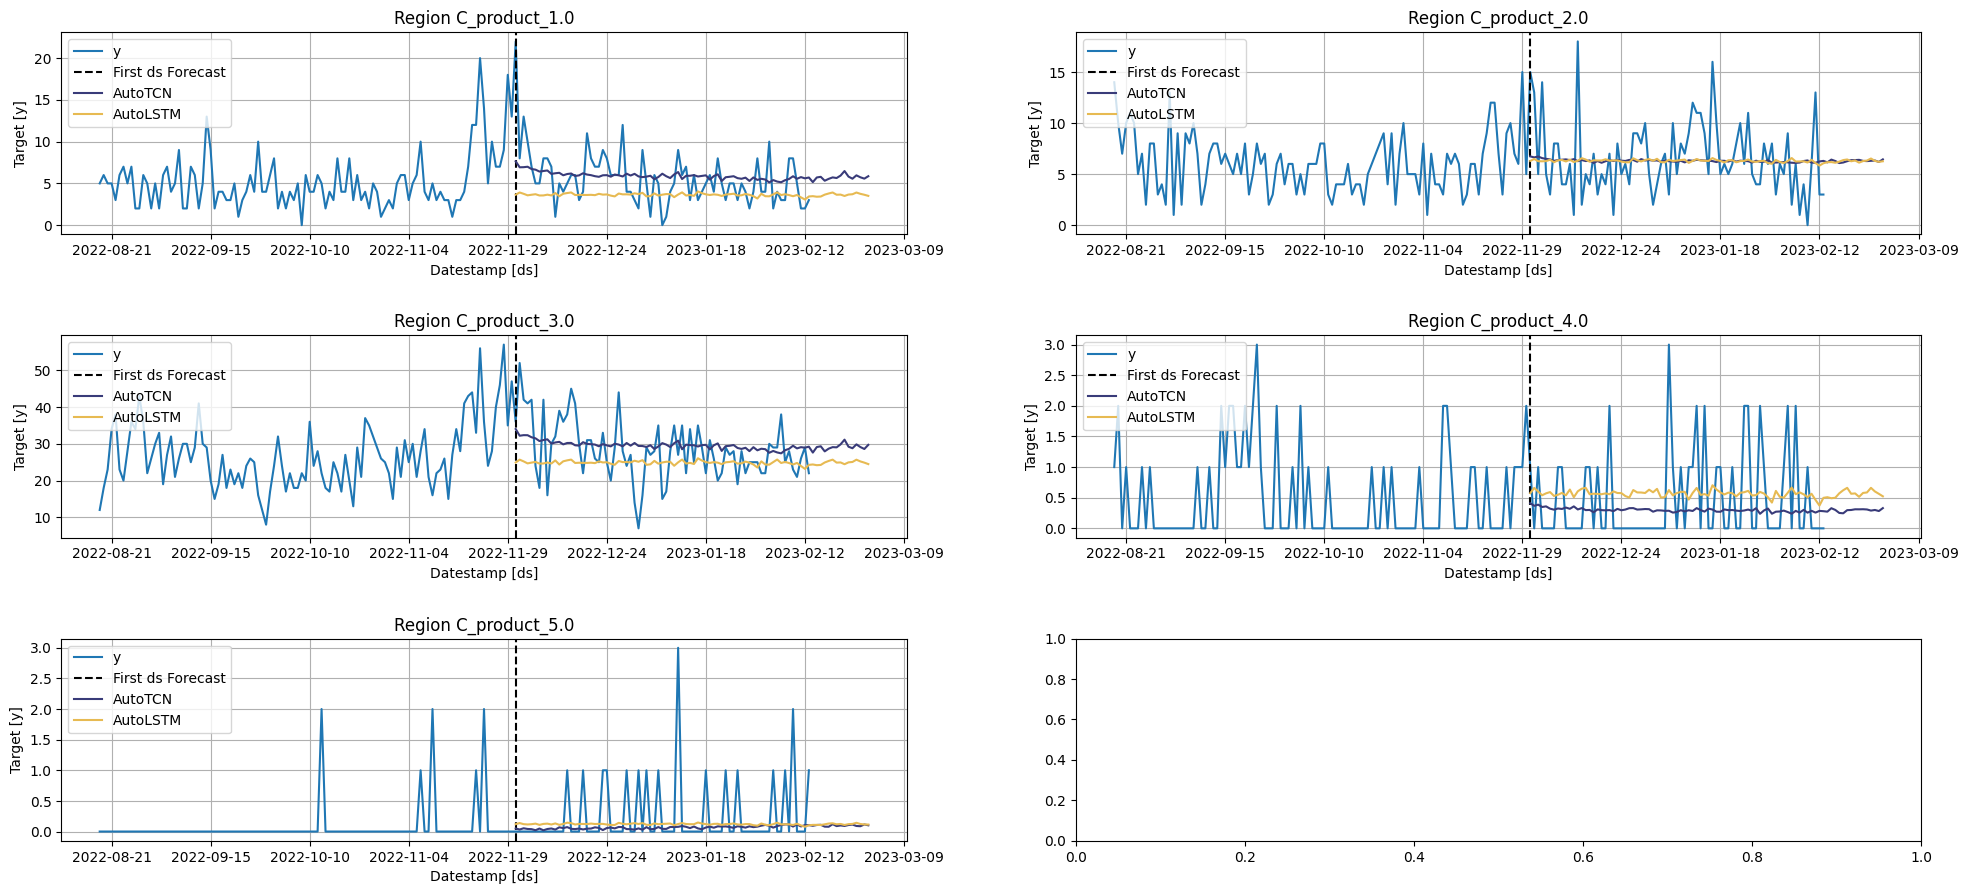

In [80]:
StatsForecast.plot(dataset[dataset["unique_id"].str.contains("Region C")], predictions[predictions["unique_id"].str.contains("Region C")], engine = "matplotlib", max_insample_length = horizon*2, level = [80, 90], plot_random=False)

Las predicciones utilizando todas las series temporales simplemente capturan el valor promedio de las series temporales, es un comportamiento esperado para modelos predictivos que no son capaces de tratar las varianzas. 

### Prediciendo la serie temporal de ventas totales en la región C

In [42]:
dataset_region_c = neuralforecast_df_region_c(data)
dataset_region_c = imput_missing_data(dataset_region_c)
dataset_region_c.drop(columns = [f"weekday_{i}" for i in range(7)], inplace=True)

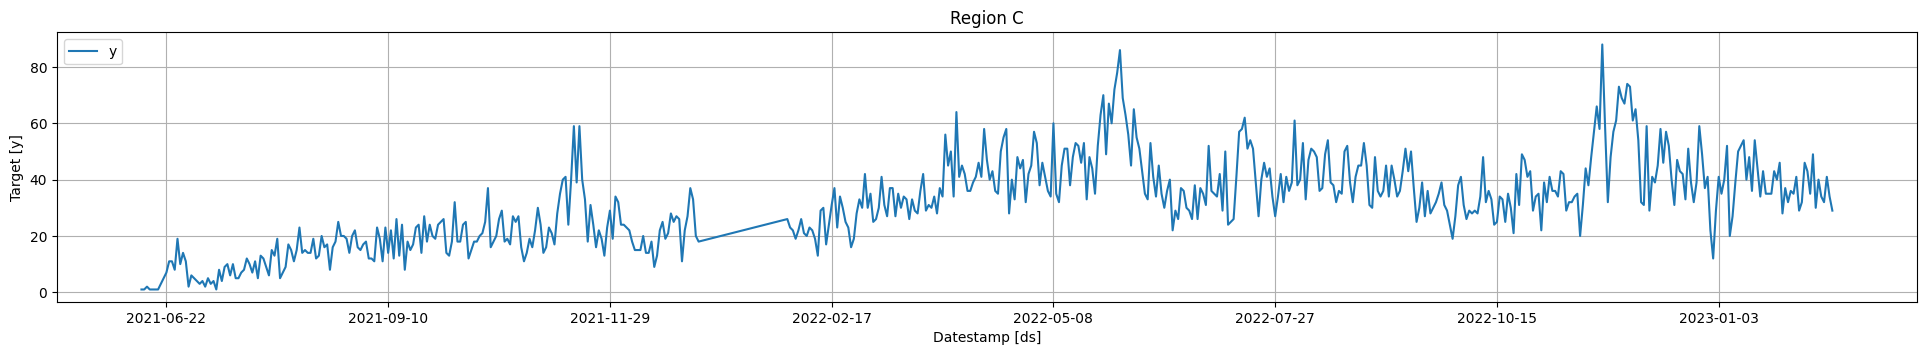

In [43]:
StatsForecast.plot(dataset_region_c, engine = "matplotlib", plot_random=False)

In [57]:
horizon = 90
default_config = {
        "input_size": tune.choice([horizon, 2*horizon, 4*horizon]),
        "learning_rate": tune.loguniform(1e-6, 1e-4),
        "max_steps": tune.choice([500, 750, 1000]),
        "batch_size": tune.choice([16, 32, 64]),
        "random_seed": tune.randint(1, 20),
    }

models_region_c = [
    AutoTCN(h = horizon, num_samples=5, config = default_config, cpus=2, verbose = True, loss = MAE()),
    AutoLSTM(h = horizon, num_samples=5, config = default_config, cpus=2, verbose = True, loss = MAE()),
]

model_region_c = NeuralForecast(models = models_region_c, freq = "D")
model_region_c.fit(dataset_region_c)

(train_tune pid=899975) Global seed set to 4 [repeated 5x across cluster]


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]                             
Sanity Checking: 0it [00:00, ?it/s]m 
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 28.06it/s, v_num=0, train_loss_step=0.889, train_loss_epoch=1.400]
Validation: 0it [00:00, ?it/s] 
Epoch 56:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.250, train_loss_epoch=1.250] [repeated 6x across cluster]
(train_tune pid=900055) 
Epoch 214:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.320, train_loss_epoch=1.320, valid_loss=0.559]        
Validation: 0it [00:00, ?it/s] [repeated 4x across cluster]
Epoch 73:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.110, train_loss_epoch=1.110] [repeated 8x across cluster]
(train_tune pid=900055)  [repeated 5x across cluster]
Epoch 331: 100%|██████████| 1/1 [00:00<00:00, 24.92it/s, v_num=0, train_loss_step=0.303, train_loss_epoch=0.303, valid_loss=0.524]
Validation: 0it [00:00, ?it/s] [repeated 4x across cluster]
Epoch 332:   0%

2023-05-15 23:20:23,651	INFO tune.py:945 -- Total run time: 87.11 seconds (87.09 seconds for the tuning loop).
Global seed set to 12


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 18.20it/s, v_num=0, train_loss_step=0.758, train_loss_epoch=0.703, valid_loss=0.390]
Validation: 0it [00:00, ?it/s] 
Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  9.21it/s, v_num=0, train_loss_step=0.758, train_loss_epoch=0.758, valid_loss=0.388]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [77]:
predictions_region_c = model_region_c.predict(df = dataset_region_c.loc[dataset_region_c["ds"] < '2022-12-01'])
predictions_region_c.reset_index(inplace=True)
predictions_region_c.sort_values(by = ["ds"], ascending=[True], inplace=True)

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

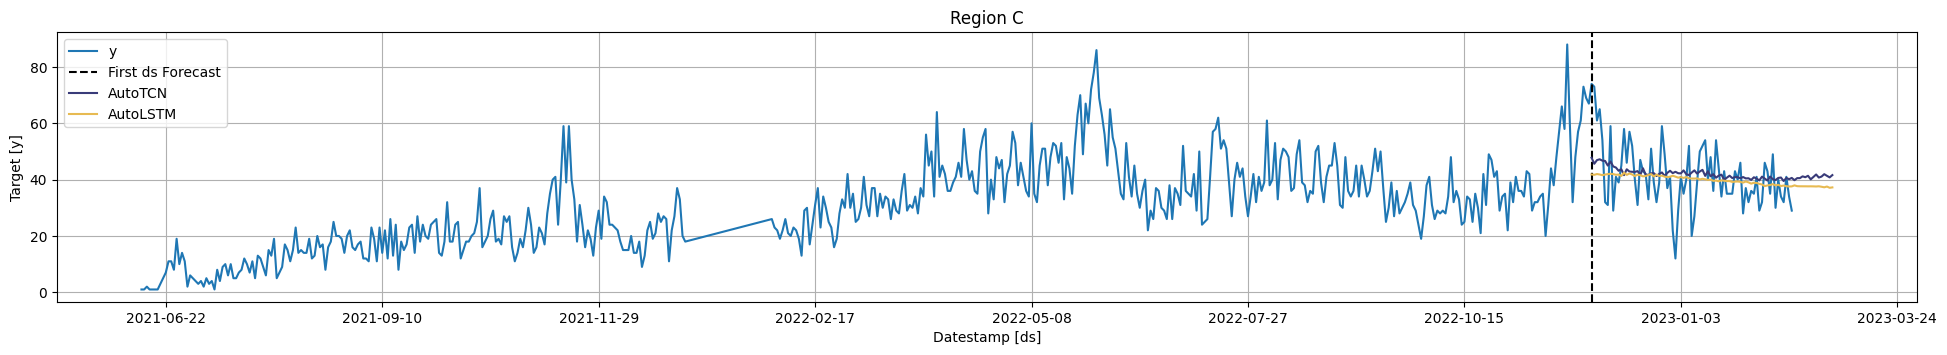

In [78]:
StatsForecast.plot(dataset_region_c, predictions_region_c, engine = "matplotlib", plot_random=False)

Aquí notamos que los modelos predictivos también predicen el valor promedio de la serie temporal, capturando poca de la varianza observado en los datos. Sin embargo, este modelo que predice únicamente una seria temporal es mucho menos complejo que el anterior que posee 20 series temporales de entrada y salida. 

A partir de este modelo sencillo, intentaremos predecir el valor de ventas totales en la región C en 2023 para cada trimestre. Utilizaremos los datos disponibles para el primer trimestre y trataremos de predecir los valores faltantes. 